# 2. Data Simulation

In this notebook, we simulate realistic synthetic financial data for training our Deep Hedging model.  
This includes underlying asset price paths, hedging instruments, and transaction costs.

---

## 📘 2.1 Hedging Target: European Call Option

We define a **European call option** as our target derivative. This option gives the right, but not the obligation, to buy the underlying asset at a fixed strike price $( K )$ at maturity $( T )$.

### 🔹 Payoff Function:

$$
Z_T = \max(S_T - K, 0)
$$

Where:
- $( S_T )$: the asset price at maturity
- $( K )$: the strike price

### 🔹 Chosen Parameters:

- **Underlying Asset**: Single stock/index (simulated)
- **Strike Price** $( K )$: 100
- **Maturity** $( T )$: 1 year (252 trading days)
- **Initial Price** $( S_0 )$: 100

This means we are simulating a 1-year ATM (at-the-money) European call option.

---

In the next step, we simulate thousands of price paths for the underlying asset using Geometric Brownian Motion (GBM).

## 📘 2.2 Simulating the Underlying Asset

We simulate many potential future paths for the underlying asset using **Geometric Brownian Motion (GBM)**, a widely used model in quantitative finance.

Each simulated path represents a possible market scenario — how the asset price could evolve over time, step by step.

### 🔹 GBM Dynamics (Discrete Form):

$$
S_{t+\Delta t} = S_t \cdot \exp\left[\left(\mu - \frac{1}{2} \sigma^2\right) \Delta t + \sigma \sqrt{\Delta t} \cdot \varepsilon_t\right]
$$

Where:
- $( \mu )$: expected return (drift)
- $( \sigma )$: volatility
- $( \varepsilon_t \sim \mathcal{N}(0, 1) )$: random noise at time $( t )$
- $( \Delta t )$: time increment (1/252 for daily steps)

This produces **log-normally distributed prices** that are always positive.

### 🔹 Simulation Parameters:

- **Initial Price** $( S_0 )$: 100
- **Drift** $( \mu )$: 0.0 (risk-neutral)
- **Volatility** $( \sigma )$: 0.2 (20%)
- **Time Horizon** $( T )$: 1 year (252 trading days)
- **Number of Simulated Paths**: e.g., 10,000

---


In [6]:
import numpy as np
import matplotlib.pyplot as plt

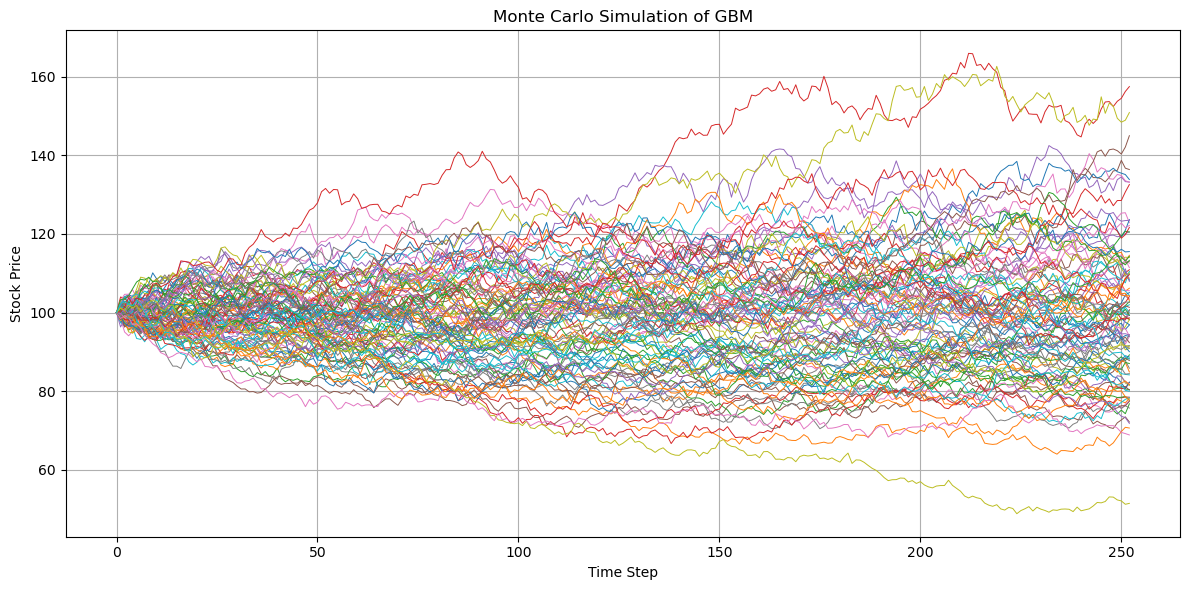

In [41]:
# Parameters
S0 = 100           # Initial stock price
T = 1              # Time to maturity in years
mu = 0.00           # Risk-free interest rate
sigma = 0.2        # Volatility
n_steps = 252       # Number of time steps for the simulation
dt = T / n_steps   # Length of each time step
n_paths = 10000
np.random.seed(42)
e_t = np.random.randn(n_paths, n_steps)

# Generate a simple stock price path with Geometric Brownian Motion
log_returns = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * e_t
log_price_paths = np.cumsum(log_returns, axis=1)
rel_price_paths = np.exp(log_price_paths)
price_paths = S0 * rel_price_paths
S0_column = np.full((n_paths, 1), S0)
price_paths = np.hstack([S0_column, price_paths])

plt.figure(figsize=(12, 6))
for i in range(min(100, n_paths)):
    plt.plot(price_paths[i], linewidth=0.7)
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.title("Monte Carlo Simulation of GBM")
plt.grid(True)
plt.tight_layout()
plt.show()

## Simulated Asset Price Paths

The plot above shows 100 simulated paths of the underlying asset using the Geometric Brownian Motion model.

Each path represents a possible trajectory of the asset price over 252 trading days, with:
- Initial price $( S_0 = 100 )$
- Drift $( \mu = 0\% )$
- Volatility $( \sigma = 20\% )$

These paths form the foundation of our training dataset for Deep Hedging.

In the next step, we enhance realism by introducing volatility spikes and possible jumps in price behavior.

## 📘 2.3 Adding Realism to Simulated Paths

To make our synthetic asset price data more reflective of real-world market behavior, we introduce three key enhancements to the basic Geometric Brownian Motion model:

---

### 🔹 Volatility Spikes

We simulate short-lived bursts of extreme volatility to reflect sudden market stress, such as earnings reports or geopolitical news. Specifically:

- Each path receives one randomly placed volatility spike.
- The spike lasts for 5–15 consecutive days.
- During this period, volatility triples from 20% to 60%.

---

### 🔹 Price Jumps

We inject rare but significant discrete jumps into the price paths to simulate sudden shocks (e.g. macroeconomic announcements or flash crashes):

- 20% of the paths include a single jump.
- The jump occurs randomly between day 30 and 240.
- Jump magnitudes range from ±5% to ±15%.

These jumps are applied directly to the price level, not the returns.

---

### 🔹 Regime Switching

Each price path experiences structured volatility regime shifts:

- **Days 0–83**: Calm regime with volatility $( \sigma = 15\% )$
- **Days 84–167**: Crisis regime with volatility $( \sigma = 40\% )$
- **Days 168–251**: Recovery/normal regime with volatility $( \sigma = 20\% )$

This models longer-term structural changes in market behavior.

---

These enhancements significantly increase the realism of the simulated environment. They challenge the Deep Hedging model to adapt dynamically — improving robustness and generalization under real-world market frictions.


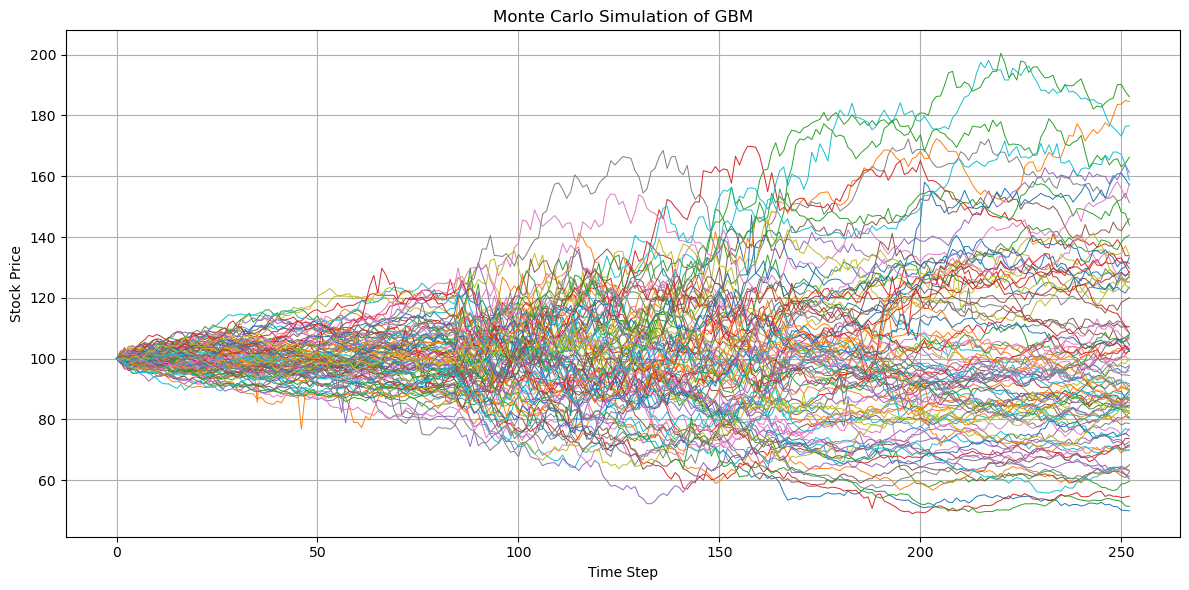

In [98]:
# Parameters
S0 = 100           # Initial stock price
T = 1              # Time to maturity in years
mu = 0.00           # Risk-free interest rate
n_steps = 252       # Number of time steps for the simulation
dt = T / n_steps   # Length of each time step
n_paths = 10000
sigma = 0.2
sigma_matrix = np.full((n_paths, n_steps), fill_value=sigma)
e_t = np.random.randn(n_paths, n_steps)

# Regime switching
sigma_calm = 0.15
sigma_volatile = 0.4

sigma_matrix[:, 0:84] = sigma_calm
sigma_matrix[:, 84:168] = sigma_volatile

# Random Volatility Spikes
start_indices = np.random.randint(50, min(200, n_steps - 5), size=n_paths)
durations = np.random.randint(5, 15, size=n_paths)
for i in range(n_paths):
    start = start_indices[i]
    end = min(start + durations[i], n_steps)
    sigma_matrix[i, start:end] = 3 * sigma

# Jumps
jump_matrix = np.zeros((n_paths, n_steps))

for i in range(n_paths):
    if np.random.rand() <= 0.2:  # 20% chance
        jump_t = np.random.randint(30, 240)
        magnitude = np.random.uniform(0.05, 0.15)
        direction = np.random.choice([-1, 1])
        jump_matrix[i, jump_t] = direction * magnitude

# Generate a simple stock price path with Geometric Brownian Motion
log_returns = (mu - 0.5 * sigma_matrix**2) * dt + sigma_matrix * np.sqrt(dt) * e_t
log_price_paths = np.cumsum(log_returns, axis=1)
rel_price_paths = np.exp(log_price_paths)
price_paths = S0 * rel_price_paths
price_paths *= (1 + jump_matrix)
S0_column = np.full((n_paths, 1), S0)
price_paths = np.hstack([S0_column, price_paths])

plt.figure(figsize=(12, 6))
for i in range(min(100, n_paths)):
    plt.plot(price_paths[i], linewidth=0.7)
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.title("Monte Carlo Simulation of GBM")
plt.grid(True)
plt.tight_layout()
plt.show()

## 📘 2.4 Compute Option Payoff

Now that we have simulated asset price paths over time, we compute the final payoff of the derivative we aim to hedge.

### Hedging Target

We assume a European call option with:
- Strike price $( K = 100 )$|
- Maturity of 1 year ($252$ steps)
  
### Payoff Formula

The payoff at maturity is:

$$
Z_T = \max(S_T - K, 0)
$$

Where:
- $( S_T )$: the final price of the underlying asset from each simulated path
- $( K )$: the strike price of the option

This value becomes the target the Deep Hedging model attempts to replicate through dynamic trading.


In [103]:
K = 100

S_T = price_paths[:,-1]
Z_T = np.maximum(S_T - K, 0)

## 📘 2.5 Building the Training Dataset

We now organize our simulated data into a structured dataset that will be used to train the Deep Hedging model.

---

### Market State Features

For each time step $( t )$ in a given path, we define the market state vector $( s_t )$ to include:

- $( S_t )$: current asset price
- $( T - t )$: time remaining to maturity (normalized)
- (Optional) rolling realized volatility
- (Optional) price history or indicators

Each path becomes a sequence of such state vectors, one per time step.

---

### Target Variable

For each path, we already computed the terminal payoff of the option:

$$
Z_T = \max(S_T - K, 0)
$$

This will be the target value the neural network is trained to hedge toward.

---

### Final Dataset Shape

Each training sample is a full episode (price path):

- `X.shape = (n_paths, n_steps, n_features)`
- `Y.shape = (n_paths,)`

This format is compatible with most deep learning frameworks, including PyTorch and TensorFlow.
